In [3]:
#Étudiants:
#1- KA Abib
#2- TOP Papa Issa
#3- TRAORÉ Haroune
#4- TRAN Thi thanh tam

In [4]:
## Importation des librairies dont on aura besoin pour ce tp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
import math

In [5]:
## Importation de la base de donnée 
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', index_col='Date')

In [6]:
dataset.index = pd.to_datetime(dataset.index.values)

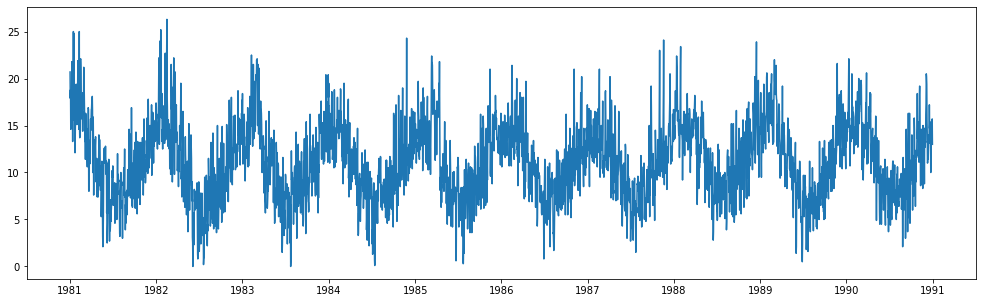

In [7]:
## plottons les temperatures afin de voir l'evolution de celles ci entre 1981 et 1991
plt.figure(figsize=(17,5))
sns.lineplot(x=dataset.index.values, y=dataset.Temp.values)
plt.show()

In [8]:
## Fonction pour spliiter notre base de donnée. Ici, nous prendrons 80% de nos données comme train et et le reste servira de test
def split(data):
    train_len = math.ceil(data.shape[0]*.8) ## l'utilisation de la fonction math.ceil ici permet d'arrondir les valeurs de temp
    test_len = math.ceil(data.shape[0] - train_len)
    train, test = data[:train_len], data[train_len:]
    train = np.array(np.split(train, train_len/10))
    test = np.array(np.split(test, test_len/10))
    return train, test
## la fonction glissement pour le modele qu'on veut utiliser permettra de prendre par exemple 10 entrées (input) 
## comme varibles explicatives et le out correspond à la variable expliquée. Donc pour exemple [T1],[T2] et [T3] seront 
## les variables explicatives et [T4] la variable expliquée. Pour la prochaine iteration, [T1],[T2],[T3] et [T4] seront
## les variables explicatives et [T5], la variable expliquée
def glissement(train, input, out):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    debut = 0
    for _ in range(len(data)):
        expliquee = debut + input
        out_end = expliquee + out
        if out_end < len(data):
            x_input = data[debut:expliquee, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[expliquee:out_end, 0])
        debut += 1
    return np.array(X), np.array(y)

In [9]:
## Appliquons notre fonction afin de splitter la dataset
train, test = split(dataset.values)

## Appliquons la fonction glissement pour mettre en place nos variables expliquées et explicatives
train_x, train_y = glissement(train, 10, 10) ## pour ce cas, nous prendrons 7 jours comme explicatives et predire les 10 suivantes
print(train_x[0])
print(train_y[0])

[[20.7]
 [17.9]
 [18.8]
 [14.6]
 [15.8]
 [15.8]
 [15.8]
 [17.4]
 [21.8]
 [20. ]]
[16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8 17.7 15.5]


In [10]:
## Mettons en place notre modele. Ici nous utiliserons un LSTM Bidirecctionnel ce qui nous permettra de garder en memoire 
## les sequences d'information futur vers passé ainsi que passé vers futur
# define parameters
verbose, epochs, batch_size = 1, 30, 30
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
model.add(Dense(n_outputs))
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

2022-04-28 01:01:05.572849: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
78/78 [==============================] - 9s 69ms/step - loss: 17.1975 - val_loss: 8.7233
Epoch 2/30
78/78 [==============================] - 6s 73ms/step - loss: 9.4194 - val_loss: 8.8528
Epoch 3/30
78/78 [==============================] - 6s 81ms/step - loss: 9.2564 - val_loss: 8.8308
Epoch 4/30
78/78 [==============================] - 6s 79ms/step - loss: 9.1886 - val_loss: 8.8568
Epoch 5/30
78/78 [==============================] - 6s 76ms/step - loss: 9.2947 - val_loss: 8.7426
Epoch 6/30
78/78 [==============================] - 7s 90ms/step - loss: 9.1300 - val_loss: 8.9182
Epoch 7/30
78/78 [==============================] - 7s 92ms/step - loss: 9.0469 - val_loss: 8.4840
Epoch 8/30
78/78 [==============================] - 7s 91ms/step - loss: 8.9317 - val_loss: 8.5175
Epoch 9/30
78/78 [==============================] - 7s 89ms/step - loss: 8.9810 - val_loss: 8.4478
Epoch 10/30
78/78 [==============================] - 8s 102ms/step - loss: 8.9251 - val_loss: 8.6318
Epoch 1

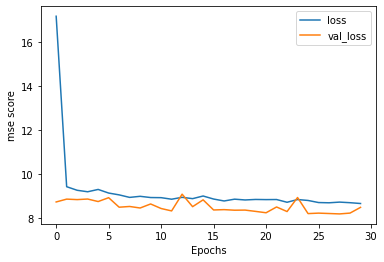

In [11]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("mse score")
plt.show()

In [12]:
## Mettons en place une fonction de prediction qui fonctionnera en fonction du nombre d'input qu'on choisira comme variables explicatives
def prediction(model, history, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

history = [x for x in train]
predictions = list()
n_input = 10 ## nous prenons toujours 10 jours de donnée afin de faire nos predictions

for i in range(len(test)):
    yhat_sequence = prediction(model, history, n_input)
    predictions.append(yhat_sequence)
    history.append(test[i, :])

## Mesurons la performance de notre modele
predictions = np.array(predictions)
y_pred = predictions.flatten()
y_test = test.flatten()

from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_lstm)

2.7985599266206456


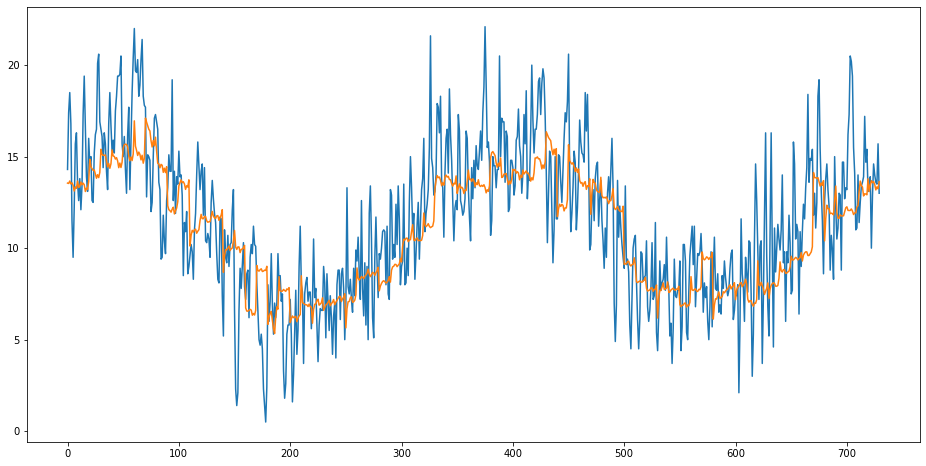

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.show()

In [14]:
## Essayons de predire les 10 jours suivants
next_pred = y_pred

curr_predictor = test[-1].reshape(1,10,1)
curr_prediction = model.predict(curr_predictor)
for x in curr_prediction:
    next_pred = np.append(next_pred, x)

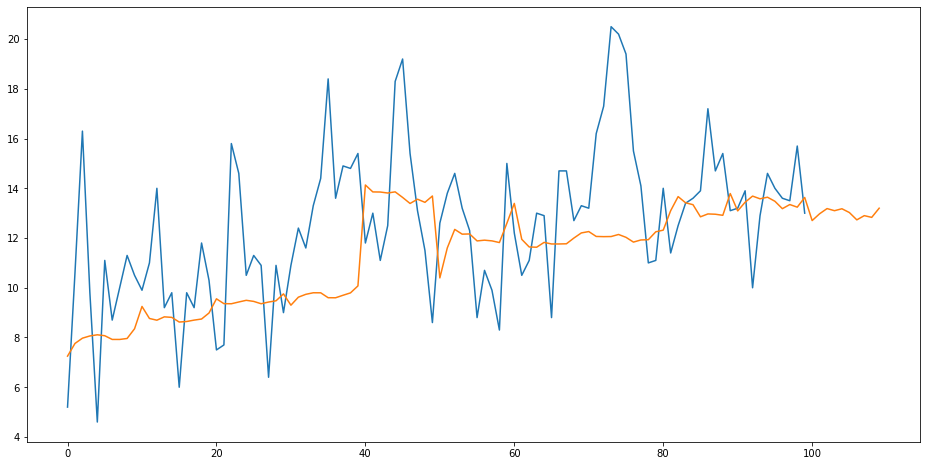

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[-100:], label='true')
plt.plot(next_pred[-110:], label='predicted')
plt.show()